We work in this notebook with the **MUTAG** dataset. 
- **Graphs are chemical compounds**:The MUTAG dataset represents chemical compounds, specifically mutagenic and non-mutagenic molecules. The graphs in the dataset describe the structure of these chemical compounds, with nodes representing atoms and edges representing chemical bonds.
- **Graph features**: Each graph in the MUTAG dataset consists of nodes, edges, and node and edge attributes. The node attributes typically represent atom types, and the edge attributes may represent bond types or other chemical properties.
- **Binary Classification**: The primary task associated with the MUTAG dataset is binary classification. Each graph is labeled as either "mutagenic" or "non-mutagenic," making it a binary classification problem.
- **Number of Graphs**: The dataset contains a relatively small number of graphs, typically around 188 graphs, split into training and testing subsets.




References:
- The paper: [TUDataset: A collection of benchmark datasets for learning with graphs](https://grlplus.github.io/papers/79.pdf)
- Github datasets: [https://chrsmrrs.github.io/datasets/](https://chrsmrrs.github.io/datasets/)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

In [2]:
def print_graph_stats(ix):
    data = dataset[ix]
    print(data)
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

def visualize_graph(G, color=None):
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="tab10", node_size=140)

def visualize(h, color=None):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure()
    plt.scatter(z[:, 0], z[:, 1], s=50, c=color, cmap="Set2")
    plt.xticks([])
    plt.yticks([])

In [3]:
dataset = TUDataset(root="data/TUDataset", name="MUTAG")

In [4]:
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: MUTAG(188)
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [5]:
print_graph_stats(0)

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
torch.manual_seed(12345)
dataset = dataset.shuffle()
train_dataset = dataset[:150]
test_dataset = dataset[150:]

/Users/marianfarah/miniconda3/envs/gnn_py9/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


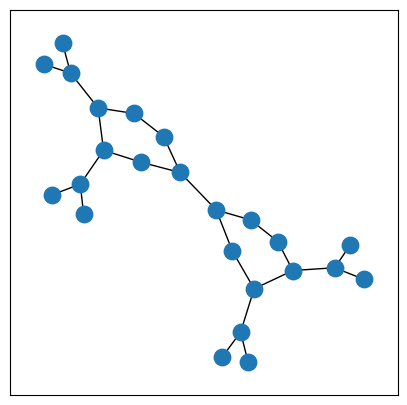

In [7]:
data = dataset[10]
G = to_networkx(data, to_undirected=True)
visualize_graph(G)

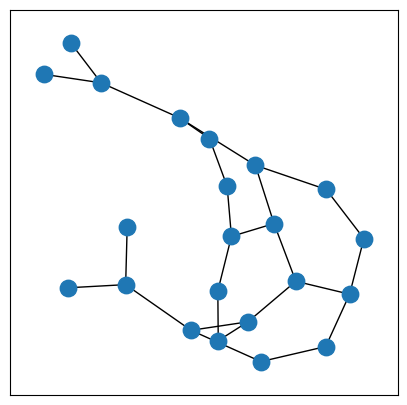

In [8]:
data = dataset[150]
G = to_networkx(data, to_undirected=True)
visualize_graph(G)

## Mini-batching of graphs

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class.

Let's try `batch_size = 64`. This results in 3 batches of the training data (randomly shuffled), where each `Batch` equipped with a `batch` vector that maps each node to its respective graph in the batch. For example: 
$$\text{batch} = [0, ..., 0, 1, ..., 1, 2, 2, ...]$$


In [9]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for step, data in enumerate(train_loader):
    print(f"Step {step + 1}:")
    print(f"Number of graphs: {data.num_graphs}")
    print(data)
    print(" ")

Step 1:
Number of graphs: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])
 
Step 2:
Number of graphs: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])
 
Step 3:
Number of graphs: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])
 


In [10]:
data.batch

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 13, 13, 13, 13, 13, 13, 

In [11]:
feature_size = dataset.num_node_features
hidden_size = 16
num_classes = dataset.num_classes

class GCN(torch.nn.Module):
    def __init__(self, hidden_size):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(feature_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, hidden_size)
        self.lin = Linear(hidden_size, num_classes)
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = F.dropout(x, p=0.5, training=self.training)
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        # 2. Readout layer (aggregate node embeddings into a graph embedding)
        h = global_mean_pool(h, batch)
        # 3. Apply a final classifier
        h = F.dropout(h, p=0.5, training=self.training)
        logits = self.lin(h)
        return logits, h

model = GCN(hidden_size)
print(model)
        

GCN(
  (conv1): GCNConv(7, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


In [12]:
# Get node embeddings from untrained GCN model
# model = GCN(hidden_size)
# model.eval()  # we don't want to run dropout
# logits=[]
# h=[]
# yc = []
# for d in train_loader:
#     logs, hs = model(d.x, d.edge_index, d.batch)
#     logits.append(logs)
#     yc.append(d.y)
#     h.append(hs)
# visualize(h[1], yc[1])

In [13]:
model = GCN(hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    correct = 0
    for batch_data in train_loader:
        optimizer.zero_grad()
        logits, _ = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        loss = criterion(logits, batch_data.y)
        preds = logits.argmax(dim=1)
        batch_correct = preds == batch_data.y
        correct += int(batch_correct.sum())
        loss.backward()
        optimizer.step()
    accuracy = correct / len(train_loader.dataset)
    return accuracy

def test():
    model.eval()
    correct = 0
    for batch_data in test_loader:
        logits, _ = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        preds = logits.argmax(dim=1)
        batch_correct = preds == batch_data.y
        correct += int(batch_correct.sum())
    accuracy = correct / len(test_loader.dataset)
    return accuracy

In [14]:
for epoch in range(1, 201):
    train_acc = train()
    test_acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.6667, Test Acc: 0.7632
Epoch: 030, Train Acc: 0.6533, Test Acc: 0.7895
Epoch: 040, Train Acc: 0.6733, Test Acc: 0.7895
Epoch: 050, Train Acc: 0.6800, Test Acc: 0.7632
Epoch: 060, Train Acc: 0.6933, Test Acc: 0.7632
Epoch: 070, Train Acc: 0.6667, Test Acc: 0.7632
Epoch: 080, Train Acc: 0.7000, Test Acc: 0.7632
Epoch: 090, Train Acc: 0.7067, Test Acc: 0.7632
Epoch: 100, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 110, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 120, Train Acc: 0.7067, Test Acc: 0.7632
Epoch: 130, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 140, Train Acc: 0.7133, Test Acc: 0.7368
Epoch: 150, Train Acc: 0.7067, Test Acc: 0.7368
Epoch: 160, Train Acc: 0.7600, Test Acc: 0.7368
Epoch: 170, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 180, Train Acc: 0.6867, Test Acc: 0.7632
Epoch: 190, Train Acc: 0.7000, Test Acc: 0.7632
Epoch: 200, Train Acc: 0.7267, Test Acc: 0.7632


In [15]:
# Get node embeddings from untrained GCN model
model.eval()  # we don't want to run dropout
H = []
Y = []
for d in train_loader:
    print(d)
    _, h = model(d.x, d.edge_index, d.batch)
    H.append(h)
    Y.append(d.y)
print(len(H), len(Y))

DataBatch(edge_index=[2, 2650], x=[1197, 7], edge_attr=[2650, 4], y=[64], batch=[1197], ptr=[65])
DataBatch(edge_index=[2, 2460], x=[1119, 7], edge_attr=[2460, 4], y=[64], batch=[1119], ptr=[65])
DataBatch(edge_index=[2, 884], x=[398, 7], edge_attr=[884, 4], y=[22], batch=[398], ptr=[23])
3 3


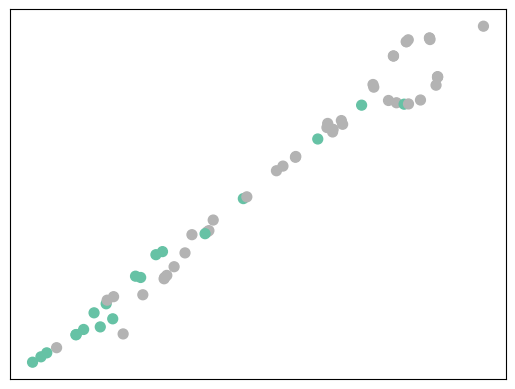

In [16]:
visualize(H[0], Y[0])

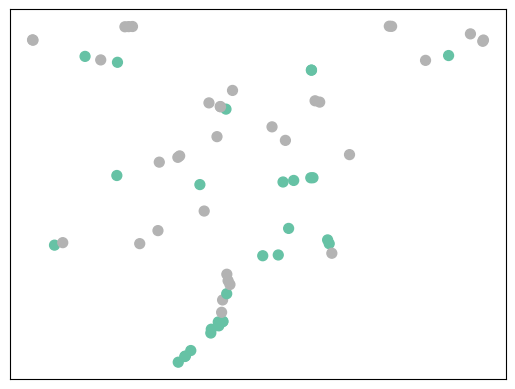

In [17]:
visualize(H[1], Y[1])

In [18]:
visualize(H[2], Y[2])

ValueError: perplexity must be less than n_samples